In [2]:
# %load_ext autotime
# !pip install autotime
%load_ext autoreload
%autoreload 2

from pathlib import Path
import os
import pandas as pd
import numpy as np

import seaborn as sns
import matplotlib.pyplot as plt

import torch

pd.set_option("display.max_columns", 500)
pd.set_option("display.max_rows", 100)
pd.set_option("max_colwidth", 1000)

base_path = Path("/scratch/project/open-35-8/pimenol1/ProteinTTT/ProteinTTT/data/bfvd")
OUTPUT_PDB = base_path / Path('predicted_structures')
CLEAN_DF_PATH = base_path / Path('to_process.tsv')
RESULTS_PATH = base_path / Path('results_with_correct_esm.tsv')

/scratch/project/open-32-14/pimenol1/miniconda3/envs/esmfold/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [46]:
len(os.listdir(OUTPUT_PDB))

636260

## Dataset

### Merging base dataset 

In [12]:
df_clean = pd.read_csv(CLEAN_DF_PATH, sep="\t")
results_old = pd.read_csv(RESULTS_PATH, sep="\t")
results_old.shape[0], df_clean.shape[0]

(317882, 317882)

In [13]:
results = pd.DataFrame(columns=df_clean.columns)
for file in os.listdir(base_path / "res_eval"):
    if file.startswith("results_"):
        temp_df = pd.read_csv(base_path / "res_eval" / file, sep="\t")
        results = pd.concat([results, temp_df.query("pLDDT_before.notna()")], ignore_index=True)
results

/tmp/ipykernel_764498/416990657.py:5: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  results = pd.concat([results, temp_df.query("pLDDT_before.notna()")], ignore_index=True)


,id,nmsa,pLDDT_AlphaFold,version,sequence,length,pLDDT_before,pLDDT_after,tm_score_before,lddt_before,tm_score_after,lddt_after,time
0,A7IUX3,3,40.184184,BASE,MYKMSLLVLTQEFQEEDMPWFGTAFLHPHVPNRGPCPSFHLDNPKNLLWVCEWYTCIYLAWDQDNQYTLGMMHTEIRRIHLPSHDRCLGFPGDTSMCCQLGLS,103,28.709551,36.696726,0.28594,0.331706,0.33734,0.350680,36.788191
1,A0A6M9TZY3,7,40.185052,BASE+LOGAN+12CY,MLLDKPDQHVITEFDAFMENDKIILNGIFNDTAKKALNLSLPLGFFSISNYIYFNLPLLEFPSFVNNYTFKDPLHKERIHYSFELSNVYNNLQTDYFNNVIRHPLPKTKPVITGIKVLPKITRSIEGPSSRINNSDKDFNHREVHLERKKPYDKKPNMRETDQQNMPPPPLPKMKKIKTTSAESAAAPSSSQPANINDIDAHLQKYHQLFTKLIQEKEFKKYQKFVDDFKVFVTPIYHVIQANTLKYKPLIETYNRYVLECFVRHWKIKTTDNLKSSLHAISNTEYDNFIASYHNFNEMYITLNDMSNIKEDPDYTIIKEFVHEIVRLIGINNNI,335,42.312089,58.246706,0.43240,0.533388,0.39168,0.544333,185.468657
2,A0A192GNL3,47,40.185311,BASE,MLPQNSQVVHGVQDGPPVGPQPAQALLKVPVDVRRQAQAGPLAGVKPRPRLGVGAHHTPGVPVPLILGAVQHVHLLPGPRGQRLGHPLDVVHPLAQHQPLYVGPEEHPVGQGGVPLGVLGLGLDHRVPVHLARDLAKLGLYVYARAEYLHLVGPGADPVHRAVLPAEKGPQCSVVVVVPHGCSAQTQQVRGPHRQENPTRHGGRQLVGLIYNQEKHCGRVLGLNPPVSQRSRTRHIQVPGQGVGRRGAGCKDPRVRKEPSRRVPPLSRQHPPVCQDEGGQPQPPPQLQGHECLAEAGRALEHAIPLGGNVAPGLLQYPFLVRSRRDGAPLPGGAVSGRRFASQDPGTPGEGDVGLSPRRKGKQVCFPRAGHVSIYRVEP,379,26.668830,28.764074,0.12965,0.622505,0.21060,0.608376,228.917387
3,A0A8A1UFW7,10,40.185707,BASE+LOGAN,MIYVYAEEERWLSNSDCIHVHRTVFFASGLYRIPYYTSSFVSVGSFSHSGYKTGFLFFWSFFAVCCILREYTLSKSCSCSIYILNIKKK,89,30.481073,33.632799,0.36591,0.614272,0.38138,0.575195,37.040655
4,A0A1V0SAK4,5,40.186713,BASE+LOGAN+12CY,MLYNNKELVIETFGGSHRSGGRHRSGGRHRSGGSRGSYSHESGGRSSYGNHRRDHHNYRSGSSKFHNRNHRHYNYGPTRHNFNRHGDVYINNNDNNYIRYNDSYPYFVDYYGPRGSLNLNDYYNPPFVQYPYYPYPYGISPDIYPDVHPGMLPNILPDASSSENTFIQYNKFPIQQTSNPEEEIQSFTNLTDPIVYSNNDYTYLYYIFSAVMVLVIVLVFFCFK,224,35.730510,40.695059,0.19140,0.738145,0.23107,0.710163,87.982680
...,...,...,...,...,...,...,...,...,...,...,...,...,...
324877,A0A2L1IWE9,63,93.670303,BASE+LOGAN,MDWLECLDAQLMRDAIRPNETYWAAYQYFDSAPWKPLNPREFLQFWGILSDEERLMVLLEIG,62,51.504337,71.163864,0.62190,0.728560,0.43014,0.483579,37.609659
324878,A0A410T6P2,668,93.670729,BASE+LOGAN,MFILANDVVVNLENVSNVNLVPNRNRIVFNMNYSIQMKHYGHKSLISDYVYWDAKDSNEYTRNLIKLKENEHFQREFFAKPKNDGFINVNEISSIKFLEDSRRIIFNLSHQVTFRDKSKNESLTSEFVYVDIGSKEAYEDYKELLLIELGL,151,75.742139,77.880681,0.81951,0.853354,0.81844,0.855309,51.004086
324879,A0A6N1NJT8,10701,93.670778,BASE,MSTTTPILATHNLSSSWSTGYQVSITVKNNTQNPTTGWTVTFQIPLNVKVSSSWNCVLSVSGQTITAKNTSSNAVIRAGASINFGVQFTKPSTAPSTISNLQAIGTFSSPTPSPDPNPTPTPSPNGKIIEGYWESWDSKVPVNTIVNMKANLIDISFGTFTQTGTNTFVVSGVEASASTIKQLVSAAHSLGKKVKLSIGGATYPISKFLTSDAAANGLAQAVAAYVKTYSLDGVDYDIEDRPAANLQIALIKYTRQILGPNYLISYTAMSPASTTSPWSTVIYGAHTYLNTVSIMAYNYGPGYTFQQDVQNLIAKGVPANKIVVGLMPGRDDVGVLTDLNHIRTACNYIKQHNLAGIMFWSLNRDYLNLTGLGSSAAINTAHSILG,386,88.593733,88.699067,0.71833,0.897720,0.72431,0.917477,0.694196
324880,H6X4A3,16,93.671705,BASE+LOGAN+12CY,MNKAQELKLCIQQLCTLRCENLRAIYEGDVIEVQRCETAIEAKEFEVNRLIDELCGEKK,59,85.141642,86.288463,0.99083,0.992313,0.93045,0.956026,37.536124


In [17]:
results.drop_duplicates('id').to_csv(base_path / Path('proteinttt_results.tsv'), sep="\t", index=False)

In [ ]:
import ast
import tqdm

def str_to_dict(s):
    d = {}
    pairs = s.split(',')
    for pair in pairs:
        if ':' in pair:
            key, value = pair.split(':', 1)
            d[key.strip()] = value.strip()
    return d


def parse_log(file):
    id_seq = file.split("_")[0]
    output_path = base_path / 'esm_fold' / f'{id_seq}.pdb'
    if output_path.exists():
        return

    log = pd.read_csv(base_path / "logs" / file, sep="\t")
    s = log['ttt_step_data'].iloc[0]
    result = str_to_dict(s)
    txt = result['{0']

    data = ast.literal_eval(txt)
    pdb_str = data["eval_step_preds"]["pdb"]

    # write to PDB
    # with open(base_path / 'esm_fold' / f'{id_seq}.pdb', "w", encoding="utf-8") as f:
    #     f.write(pdb_str.rstrip("\n") + "\n")
    #     if not pdb_str.strip().endswith(("END", "ENDMDL")):
    #         f.write("END\n")

    output_path.write_text(pdb_str)
    
for file in tqdm.tqdm(os.listdir(base_path / 'logs')):
    parse_log(file)

100%|██████████| 318012/318012 [00:49<00:00, 6374.78it/s]


In [8]:
df = pd.concat([results_old, results], ignore_index=True)
df.shape[0], df.drop_duplicates('id').shape[0]

(317882, 317882)

In [11]:
df = df.drop_duplicates('id').reset_index(drop=True).sort_values('pLDDT_AlphaFold')
df.to_csv(base_path / 'results_with_correct_esm.tsv', sep="\t", index=False)

In [12]:
df['diff_pLDDT'] = df['pLDDT_after'] - df['pLDDT_before']
df['diff_pLDDT_AlphaFold'] = df['pLDDT_after'] - df['pLDDT_AlphaFold']

In [20]:
df.query("diff_pLDDT > 20 and pLDDT_after > 80").sort_values('diff_pLDDT_AlphaFold', ascending=False).head(30)

,id,nmsa,pLDDT_AlphaFold,version,sequence,length,pLDDT_before,pLDDT_after,tm_score_before,lddt_before,tm_score_after,lddt_after,time,diff_pLDDT,diff_pLDDT_AlphaFold
6610,Q53CV7,74,37.985246,BASE,MAMSWGYMWITEQGTLFPAPGTTQRETTHSVLCDPVPNFRFFMLWVYCANSPFPPFPATRFPSTQSLFTLGVALAPVKDPRSLSFW,86,31.267159,86.207435,0.39592,0.478247,0.14159,0.218115,37.565845,54.940275,48.222188
5535,A0A1Y0SXX4,90,37.068308,BASE,MTTAVLTPKFILSDCRVTSTITVKDQQGTEHKVKGSTDTYSKQGDLNIREPEGDHNLEAYVIFGEIPTAEALVALAKATGFVNITMVLAAVAMFNIKVPTTPTGFAWVNGSGRIGWLIIEDGQYLLGYAPEGTEYVCFGSGKGYFEASYERTGDILTAFTQAIHRDPLSSDLTYDHHDVESGVTSRMVLSQAEVPTLETLLPVLDATA,208,31.903270,83.638119,0.37440,0.469854,0.27018,0.409834,78.012562,51.734848,46.569811
7130,A0A6G9LDI1,70,38.412031,BASE,MRVTVGGQEFEARDLNSKVTVSVFPGSRGEFEIEANKLLALSAEEFGEPDVYGAGGHHAWVSRETRDYMVEVTIFAPSGMNEQDIRDHLAGA,92,43.372468,84.622003,0.39139,0.558299,0.31937,0.478877,35.756114,41.249535,46.209972
12224,A0A3G4ZNZ4,34,42.001193,BASE,MGNIVSDYLSYEFMSSLSMKIGMGVVMTTGIITGVYYVLRKPIKKIIAKETTSVTQHLMSDEKTMKTANDFITSIITNDSITTKVKVVLISMMESPDVKNAIDKLLQSIMSNPETMVSVKKFISDTVSDPDVQNNLLIVVTNIISDNTFTIKITETFVEMMGSAEIKNSINSMLQNVLNDPETQTTVKNFALNLLGDEAIKKELFTMMAGIMKDDEIRTQISGFLVSVLKDVEVNKELYESLKKLITEIADDEETNKIIVTFISSTVLKAIDDNDEAIKKRIIALLTSQEVTDAVEKSIMDVVQRDDLKRTIGDNAVDALVLAIKKYFPKTLGLMV,336,62.106053,87.353460,0.27165,0.413801,0.19593,0.434095,184.751823,25.247407,45.352267
4966,A0A6J5L119,54,36.544031,BASE,MSDDHFTLCTEAPCLAEHQLVTWRPPLLSKLHRLPVIRAKSISSWGEREIELSKVHTARGRFLADRKTGTLYHLTGECVTSAFMRVVL,88,50.033248,81.422123,0.34816,0.416318,0.15308,0.219926,38.918021,31.388875,44.878091
13079,A0A345MMR4,38,42.532383,BASE,MLFECYIIITKSVHKKIISNKKYKVEVKHGRITYIMINNKWVRFPCEDTFYKMYSTKCKFIKNFLENEKGDIVDITLSSDKKTFIYRGEIYNTEEYLKIL,100,47.425739,87.316631,0.35177,0.431053,0.39012,0.508695,35.378680,39.890892,44.784249
7320,A0A345MMK4,4,38.548581,BASE+LOGAN+12CY,MDKSKSFYVRCRNNKIPPTDIKRKKSLTINKIYVCDKIITPMVLYIINDNGEYVSYGSSRFEIKTKIYKHIHKDYSVGGVLSIDKKNIIFTDGSGYSHAKYYKEVV,106,60.341073,82.901603,0.35916,0.430052,0.31471,0.413517,36.910865,22.560531,44.353022
24361,A0A516LZS1,6,48.486806,BASE+LOGAN+12CY,MDTNVKSYIETMKLLMSIGSVEDITDFSVAYDNLQASAFGYLLAKDVVSDENSFGNTVLEPVVEAVKEVYGEPNIGNLYKLITETVV,87,61.753448,91.573522,0.33660,0.550465,0.31997,0.550714,35.637049,29.820075,43.086716
12911,A0A886NIW7,4,42.426862,BASE+LOGAN+12CY,MNGDILLEIFTQISDFGAVNGFARLCKKCSEIVRGNLPELTRRFVEIKTLEGVDKEDEGYFMIKYQQWPNEIKHGIYHYYFTEAGFGTKYYFDTYTIYNFGKEMCVARIDGYKNHRDHEYRCGKYKYNIVSHAGQPSLFTKTSEVGGVVRRCEYTIEGAVITEHASWRIGAKVLKERTQVVNGIYELVPVLAAINDIAIRADKLKK,206,63.225101,85.355358,0.36792,0.404397,0.38753,0.423630,75.517220,22.130257,42.928496
6962,A0A8D9C966,4,38.272821,BASE+LOGAN+12CY,MFNLTSSELQPNKFYKYGSNTIQFIEDLGGREYRPAIEDINGEVIIDALWVAVLKIKIVGYSGVENTNRPIQIKISEQTTEISPTAKFFSEDVDMEKIKRYIKIEQDRISNIEGNLKFLNEIIWSK,126,43.957617,80.483385,0.36809,0.468897,0.33690,0.507169,41.635003,36.525768,42.210564


In [10]:
# df_clean = pd.concat([df_clean, df_new], ignore_index=True).reset_index(drop=True)
df_clean.shape[0], df_clean[~df_clean.id.isin(df.id)].shape[0]

(488, 1)

In [14]:
df_clean = df_clean[~df_clean.id.isin(df.id)].drop_duplicates('id')
df_clean.to_csv(CLEAN_DF_PATH, sep="\t", index=False)
df_clean.shape[0]

0

In [ ]:
df['diff_alphafold'] = df['pLDDT_after'] - df['plddt_AlphaFold']
df['diff_esmfold'] = df['pLDDT_after'] - df['pLDDT_before']
df = df.sort_values('diff_alphafold', ascending=False).reset_index(drop=True)
df[['id', 'plddt_AlphaFold', 'pLDDT_before', 'pLDDT_after', 'diff_alphafold', 'diff_esmfold']].query("pLDDT_after > 90").head(20)

,id,plddt_AlphaFold,pLDDT_before,pLDDT_after,diff_alphafold,diff_esmfold
0,D9I638,34.970780,68.245653,86.420350,51.449570,18.174697
1,A0A2D1GN07,35.401729,67.480757,84.389921,48.988192,16.909164
2,A0A0U2SAI9,33.150204,32.305160,81.254745,48.104541,48.949585
3,A0A6G5Y4Q2,30.361990,61.629125,78.378090,48.016100,16.748965
4,A0A6N3IKL3,34.006078,55.247447,81.875618,47.869540,26.628170
5,A0A3G5A3B6,37.209442,64.636531,84.603320,47.393878,19.966789
6,A0A2I7RYL9,32.585502,65.114141,79.540568,46.955066,14.426426
7,A0A386KPX7,30.300997,67.907449,76.315031,46.014034,8.407582
8,A0A514CTB1,33.680400,65.814355,79.546236,45.865836,13.731882
9,A0A6G6XY90,33.147274,67.741574,78.791702,45.644428,11.050129


In [22]:
df['diff_tm_esm'] = df['tm_score_after_original'] - df['tm_score_before_original']
df['diff_tm_alphafold'] = df['tm_score_after_original'] - df['tm_score_after_AlphaFold']
df = df.sort_values('diff_tm_esm', ascending=False).reset_index(drop=True)
df[['id', 'tm_score_after_AlphaFold', 'tm_score_before_original', 'tm_score_after_original', 'plddt_AlphaFold', 'diff_tm_alphafold', 'diff_tm_esm']].head(30)

,id,tm_score_after_AlphaFold,tm_score_before_original,tm_score_after_original,plddt_AlphaFold,diff_tm_alphafold,diff_tm_esm
0,UPI0009AAEB55,NaN,0.13030,0.75563,84.757770,NaN,0.62533
1,UPI000035883D,NaN,0.28484,0.81859,90.973590,NaN,0.53375
2,UPI0000110744,NaN,0.16058,0.68217,85.661616,NaN,0.52159
3,UPI0000112E3F,0.77539,0.28425,0.75913,89.065147,-0.01626,0.47488
4,UPI0018C8D4D4,NaN,0.23925,0.69513,91.795834,NaN,0.45588
5,UPI0001B04C70,NaN,0.25212,0.69185,85.919240,NaN,0.43973
6,UPI0007F04AD2,0.89760,0.46968,0.84899,87.167514,-0.04861,0.37931
7,A7XXR5,0.70590,0.33501,0.70634,76.530336,0.00044,0.37133
8,UPI000DCF63DB,0.72536,0.37536,0.73422,88.420012,0.00886,0.35886
9,UPI0008A09DB8,0.80068,0.47233,0.79570,87.434978,-0.00498,0.32337


In [16]:
results['difference_plddt'] = results['pLDDT_after'] - results['pLDDT_before']
results.sort_values('difference_plddt', ascending=True).reset_index(drop=True)[['id', 'pLDDT_before', 'pLDDT_after', 'difference_plddt']].query("difference_plddt < 0").head(20)

,id,pLDDT_before,pLDDT_after,difference_plddt
0,A0A7G8LDJ5,30.216108,30.216108,-3.552714e-15
1,A0A481YQL7,30.572712,30.572712,-3.552714e-15
2,A0A1X9T544,30.393046,30.393046,-3.552714e-15
3,A0A6J5LDX8,30.868354,30.868354,-3.552714e-15
4,A0A0F7L894,31.831574,31.831574,-3.552714e-15
5,A0A2D1A4P3,30.701689,30.701689,-3.552714e-15


In [1]:
import pandas as pd
import numpy as np
import re
import io

import ast

def parse_pdb_log_data(defaultdict_string):
    pdbs_by_step = {}
    try:
        match = re.search(r'\{.*\}', defaultdict_string, re.DOTALL)
        if not match:
            print("Could not find a dictionary structure in the PDB data string.")
            return pdbs_by_step

        dict_string = match.group(0)
        pdb_data_dict = ast.literal_eval(dict_string)
        for step, value_dict in pdb_data_dict.items():
            pdb_content = value_dict.get('eval_step_preds', {}).get('pdb')
            if pdb_content:
                pdbs_by_step[int(step)] = pdb_content

    except (ValueError, SyntaxError) as e:
        print(f"Could not parse the PDB data string: {e}")

    return pdbs_by_step

def parse_logs(file):
    output_path = base_path / 'logs_df' / file
    if output_path.exists():
        return
    
    log = pd.read_csv(base_path / 'logs' / file, sep="\t")
    raw_data_list = log.df.iloc[0].split("\n")
    raw_data_string = "\n".join(raw_data_list[:-2])
    data_io = io.StringIO(raw_data_string)
    df = pd.read_csv(data_io,sep='\s+', index_col=0)
    if '...' in df.columns:
        df = df.drop(columns=['...'])
    df['pdb'] = None
    
    t = log['ttt_step_data'].iloc[0]
    p = parse_pdb_log_data(t)
    df['pdb'] = df.index.map(p)
    df.to_csv(output_path, sep="\t", index=False)
    

In [ ]:
import tqdm
for file in tqdm.tqdm(os.listdir(base_path / 'logs')):
    parse_logs(file)

 86%|████████▌ | 272988/318012 [1:45:08<43:23, 17.29it/s]  

## Plots

Entries with pLDDT before and after: 324,882


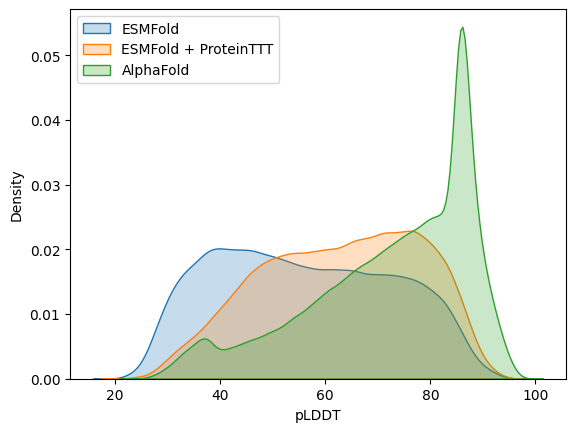

In [ ]:
sub_df = df.query("pLDDT_before.notna() and pLDDT_after.notna()")
print(f"Entries with pLDDT before and after: {len(sub_df):,}")

sns.kdeplot(sub_df['pLDDT_before'], label='ESMFold', fill=True)
sns.kdeplot(sub_df['pLDDT_after'], label='ESMFold + ProteinTTT', fill=True)
sns.kdeplot(sub_df['pLDDT_AlphaFold'], label='AlphaFold', fill=True)
plt.xlabel('pLDDT')
plt.legend()
plt.show()

In [52]:
df.plddt_AlphaFold.describe()

count    305222.000000
mean         73.235605
std          14.519720
min          24.365400
25%          63.896735
50%          76.719479
75%          85.510349
max          97.872337
Name: plddt_AlphaFold, dtype: float64

In [36]:
sub_df.tm_score_after.describe(), sub_df.tm_score_before.describe()

(count    186985.000000
 mean          0.461059
 std           0.184413
 min           0.075130
 25%           0.310390
 50%           0.422570
 75%           0.586940
 max           0.993960
 Name: tm_score_after, dtype: float64,
 count    187024.000000
 mean          0.450261
 std           0.170658
 min           0.070630
 25%           0.312890
 50%           0.415700
 75%           0.565610
 max           0.986200
 Name: tm_score_before, dtype: float64)

In [12]:
df.lddt_after.describe(), df.lddt_before.describe()

(count    48.000000
 mean      0.446614
 std       0.180932
 min       0.185748
 25%       0.282080
 50%       0.407616
 75%       0.561028
 max       0.792706
 Name: lddt_after, dtype: float64,
 count    87.000000
 mean      0.504442
 std       0.239873
 min       0.163724
 25%       0.304979
 50%       0.415594
 75%       0.733089
 max       0.973206
 Name: lddt_before, dtype: float64)

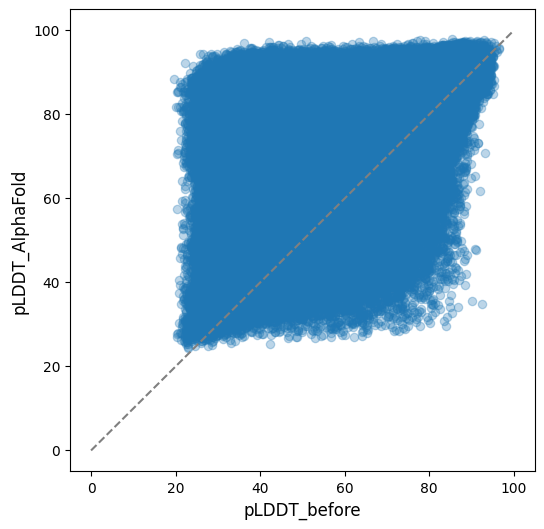

In [18]:
fig, ax = plt.subplots(figsize=(6, 6))
sc = ax.scatter(sub_df['pLDDT_before'], sub_df['pLDDT_AlphaFold'], alpha=0.3, linewidths=0.9)

ax.plot([0, 100], [0, 100], linestyle='--', color='grey', label='y=x')

ax.set_xlabel("pLDDT_before", fontsize=12)
ax.set_ylabel("pLDDT_AlphaFold", fontsize=12)
plt.show()

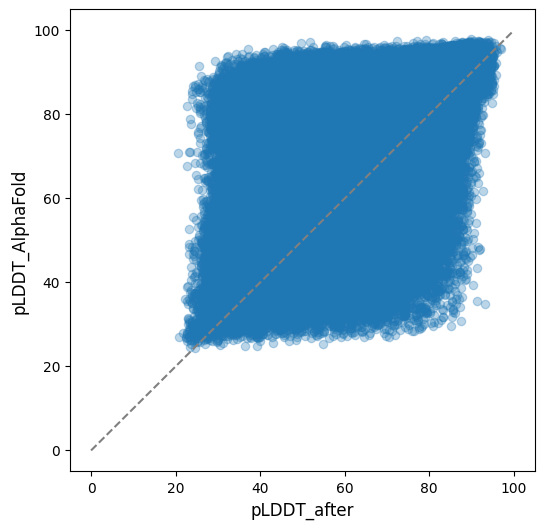

In [19]:
fig, ax = plt.subplots(figsize=(6, 6))
sc = ax.scatter(sub_df['pLDDT_after'], sub_df['pLDDT_AlphaFold'], alpha=0.3, linewidths=0.9)

ax.plot([0, 100], [0, 100], linestyle='--', color='grey', label='y=x')

ax.set_xlabel("pLDDT_after", fontsize=12)
ax.set_ylabel("pLDDT_AlphaFold", fontsize=12)
plt.show()

nan nan


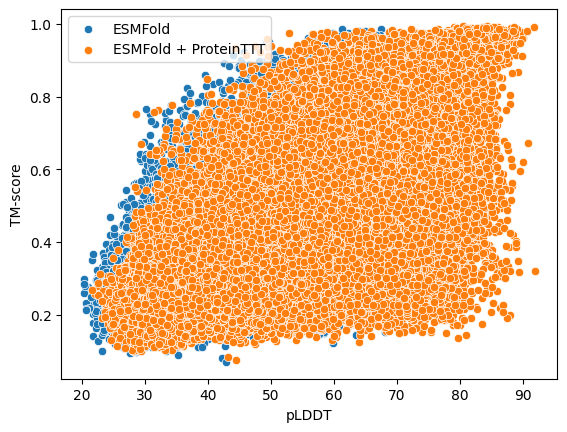

In [14]:
print(np.corrcoef(sub_df['pLDDT_before'], sub_df['tm_score_before'])[0, 1], np.corrcoef(sub_df['pLDDT_after'], y=sub_df['tm_score_after'])[0, 1])
sns.scatterplot(data=sub_df, x='pLDDT_before', y='tm_score_before', label='ESMFold')
sns.scatterplot(data=sub_df, x='pLDDT_after', y='tm_score_after', label='ESMFold + ProteinTTT')
plt.xlabel('pLDDT')
plt.ylabel('TM-score')
plt.legend()
plt.show()

nan nan


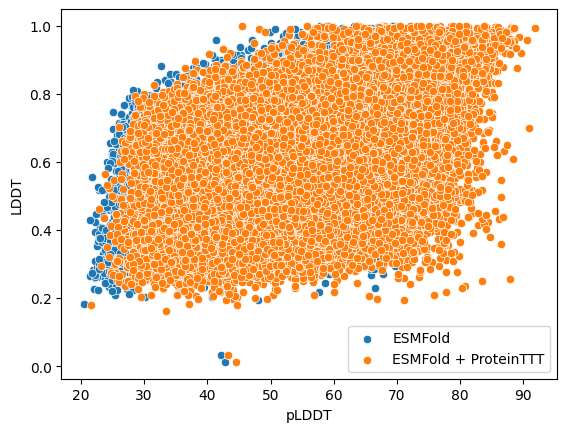

In [27]:
print(np.corrcoef(sub_df['pLDDT_before'], sub_df['lddt_before'])[0, 1], np.corrcoef(sub_df['pLDDT_after'], sub_df['lddt_after'])[0, 1])
sns.scatterplot(sub_df, x='pLDDT_before', y='lddt_before', label='ESMFold')
sns.scatterplot(sub_df, x='pLDDT_after', y='lddt_after', label='ESMFold + ProteinTTT')
plt.xlabel('pLDDT')
plt.ylabel('LDDT')
plt.legend()

In [28]:
sub_df['tm_score_difference'] = sub_df['tm_score_after'] - sub_df['tm_score_before']
plt.figure(figsize=(6, 6))
sns.boxplot(data=sub_df[['tm_score_difference']])
sns.swarmplot(data=sub_df[['tm_score_difference']], color=".25")
plt.ylabel('tm_score_difference')
# plt.xticks([0, 1], ['tm_score_difference'])
plt.show()

/tmp/ipykernel_1306274/709628841.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sub_df['tm_score_difference'] = sub_df['tm_score_after'] - sub_df['tm_score_before']


KeyboardInterrupt: 

Error in callback <function flush_figures at 0x1472f54f05e0> (for post_execute), with arguments args (),kwargs {}:


KeyboardInterrupt: 

In [14]:
sub_df.pLDDT_before.describe(), sub_df.pLDDT_after.describe()

(count    78680.000000
 mean        49.027842
 std         12.158377
 min         20.331049
 25%         38.786255
 50%         48.721753
 75%         59.705194
 max         69.998968
 Name: pLDDT_before, dtype: float64,
 count    78680.000000
 mean        57.656607
 std         12.239061
 min         21.599748
 25%         48.463769
 50%         58.670126
 75%         67.542062
 max         91.803119
 Name: pLDDT_after, dtype: float64)

In [ ]:
sub_df

## Priority

In [ ]:
column_names = ['id', 'pdb_id', 'col1', 'col2', 'col3', 'col4', 'col5', 'col6', 'col7', 'col8', 'col9', 'col10']
df_100 = pd.read_csv(base_path / Path('bfvd_pdb100_mapping_lddt_nmsa_tophit.tsv'), sep='\t', names=column_names, header=None)
df_100

In [33]:
from proteinttt.utils.parsers import download_structure_and_extract_chain
df = pd.read_csv(base_path / Path('priority_sequences.tsv'), sep='\t')
df

,id,pdb_id,pdb,chain,sequence,lenghth,pLDDT_after,pLDDT_before,plddt_AlphaFold,tm_score_before_AlphaFold,tm_score_after_AlphaFold,lddt_before_AlphaFold,lddt_after_AlphaFold,tm_score_before_original,tm_score_after_original,lddt_before_original,lddt_after_original
0,A0A068EP60,6yf7_AA,6yf7,AA,MSITKYSESAGPIGQSIYTFTGVTVPAQYMPRLVATTTVNKAGTNIEYKIAVNYPLVSVVDGANVALNTIRANLSFTALQSVINTDEKLRVLDEIV...,116,57.062431,44.714117,85.722385,0.56515,0.68990,0.707223,0.801189,NaN,NaN,NaN,NaN
1,A0A097I2D0,7n8n_C,7n8n,C,MSKAGKKVKAQQHGHLADHVSVGETQIPKASTQHLLRKAGSLSAAGDTEVPIRGFVHMKLHKLVQKSLLAMQLAKRKTIMKSDVKKAAELMHLPVF...,216,NaN,81.867753,79.719927,0.81715,NaN,0.808683,NaN,0.76943,NaN,NaN,NaN
2,A0A0A0U955,6djy_D,6djy,D,MIDLRLEEDILTATLPEFLSTRPKYRYAYTNTKQQDIRFQGPMRHVRLTHLYKQTKLWNLQYIERELAISEIDDALDEFIQTFSLPYVIEQGTYKY...,1056,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,A0A0A1IVS8,6yse_A,6yse,A,MKSPYEAAHERALMVNRLQKLTRMLRVHPDPKWKQEQQELIKRLKK,46,NaN,84.480987,89.373722,0.90924,NaN,0.978661,NaN,0.79824,NaN,0.946639,NaN
4,A0A0X1KHD2,5bpe_A,5bpe,A,GPAFEFAVAMMKRNSSTVKTEYGEFTMLGIYDRWAVLPRHSKPGPTILMNDQEVGVLDAKELVDKDGTNLELTLLKLNRNEKFRDIRGFLAKEEVE...,180,NaN,87.086629,92.159366,0.99644,NaN,0.991329,NaN,0.99047,NaN,0.967698,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
288,UPI002249A336,7xc3_A,7xc3,A,FQHMGTVSWNLREMLAHAEETRKLMPVCVETKAIVSTIQRKYKGIKIQEGVVDYGARFYFYTSKTTVASLINTLNDLNETLVTMPLGYVTHGLNLE...,129,60.894505,36.735545,92.220317,0.41014,0.35038,0.381455,0.327634,0.41775,0.35142,NaN,NaN
289,UPI002249A33C,8a55_A,8a55,A,MEKTHVQLSLPVLQVRDVLVRGFGDSVEEVLSEARQHLKDGTCGLVEVEKGVLPQLEQPYVFIKRSDARTAPHGHVMVELVAELEGIQYGRSGETL...,118,43.609435,32.599739,85.082185,0.27511,NaN,0.352780,NaN,0.29808,0.31438,0.250078,0.275978
290,UPI0022AB4E73,8hda_B,8hda,B,GSHMYKSVNITFELDERIDKVLNEKCSAYTVELGTEVNEFACVVADAVIKTLQPVSELLTPLGIDLDEWSMATYYLFDESGEFKLASHMYCSFYPPDE,98,62.616521,45.697022,88.754365,0.47669,0.43342,0.428792,0.403604,0.48330,0.43869,NaN,NaN
291,UPI002348EE55,7n0i_H,7n0i,H,GNVTQAFGRRGPEQTQGNFGDQELIRQGTDYKHWPQIAQFAPSASAFFGMSRIGMEVTPSGTWLTYTGAIKLDDKDPNFKDQVILLNKHIDAYKTF...,100,41.450442,35.584463,85.793401,0.40000,0.27390,0.494298,0.362563,0.36706,0.27374,NaN,NaN


In [ ]:
# df = df.merge(df_100[['id', 'pdb_id']], on='id', how='left', suffixes=('', '_100'))

In [60]:
from proteinttt.utils.parsers import download_chain_cif_to_pdb

for i, row in df.iterrows():
    pdb = row['pdb_id'].split('_')[0]
    chain_id = row['pdb_id'].split('_')[1]
    if pd.notna(row['tm_score_before_original']):
        continue
    # df.loc[i, 'chain'] = chain_id
    # df.loc[i, 'pdb'] = pdb
    download_chain_cif_to_pdb(pdb, chain_id, f"{pdb}_{chain_id}.pdb")    

Could not find _atom_site data in the CIF file.
Could not find _atom_site data in the CIF file.


IndexError: list index out of range

In [59]:
df

,id,pdb_id,pdb,chain,sequence,lenghth,pLDDT_after,pLDDT_before,plddt_AlphaFold,tm_score_before_AlphaFold,tm_score_after_AlphaFold,lddt_before_AlphaFold,lddt_after_AlphaFold,tm_score_before_original,tm_score_after_original,lddt_before_original,lddt_after_original
0,A0A068EP60,6yf7_AA,6yf7,AA,MSITKYSESAGPIGQSIYTFTGVTVPAQYMPRLVATTTVNKAGTNIEYKIAVNYPLVSVVDGANVALNTIRANLSFTALQSVINTDEKLRVLDEIV...,116,57.062431,44.714117,85.722385,0.56515,0.68990,0.707223,0.801189,NaN,NaN,NaN,NaN
1,A0A097I2D0,7n8n_C,7n8n,C,MSKAGKKVKAQQHGHLADHVSVGETQIPKASTQHLLRKAGSLSAAGDTEVPIRGFVHMKLHKLVQKSLLAMQLAKRKTIMKSDVKKAAELMHLPVF...,216,NaN,81.867753,79.719927,0.81715,NaN,0.808683,NaN,0.76943,NaN,NaN,NaN
2,A0A0A0U955,6djy_D,6djy,D,MIDLRLEEDILTATLPEFLSTRPKYRYAYTNTKQQDIRFQGPMRHVRLTHLYKQTKLWNLQYIERELAISEIDDALDEFIQTFSLPYVIEQGTYKY...,1056,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,A0A0A1IVS8,6yse_A,6yse,A,MKSPYEAAHERALMVNRLQKLTRMLRVHPDPKWKQEQQELIKRLKK,46,NaN,84.480987,89.373722,0.90924,NaN,0.978661,NaN,0.79824,NaN,0.946639,NaN
4,A0A0X1KHD2,5bpe_A,5bpe,A,GPAFEFAVAMMKRNSSTVKTEYGEFTMLGIYDRWAVLPRHSKPGPTILMNDQEVGVLDAKELVDKDGTNLELTLLKLNRNEKFRDIRGFLAKEEVE...,180,NaN,87.086629,92.159366,0.99644,NaN,0.991329,NaN,0.99047,NaN,0.967698,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
288,UPI002249A336,7xc3_A,7xc3,A,FQHMGTVSWNLREMLAHAEETRKLMPVCVETKAIVSTIQRKYKGIKIQEGVVDYGARFYFYTSKTTVASLINTLNDLNETLVTMPLGYVTHGLNLE...,129,60.894505,36.735545,92.220317,0.41014,0.35038,0.381455,0.327634,0.41775,0.35142,NaN,NaN
289,UPI002249A33C,8a55_A,8a55,A,MEKTHVQLSLPVLQVRDVLVRGFGDSVEEVLSEARQHLKDGTCGLVEVEKGVLPQLEQPYVFIKRSDARTAPHGHVMVELVAELEGIQYGRSGETL...,118,43.609435,32.599739,85.082185,0.27511,NaN,0.352780,NaN,0.29808,0.31438,0.250078,0.275978
290,UPI0022AB4E73,8hda_B,8hda,B,GSHMYKSVNITFELDERIDKVLNEKCSAYTVELGTEVNEFACVVADAVIKTLQPVSELLTPLGIDLDEWSMATYYLFDESGEFKLASHMYCSFYPPDE,98,62.616521,45.697022,88.754365,0.47669,0.43342,0.428792,0.403604,0.48330,0.43869,NaN,NaN
291,UPI002348EE55,7n0i_H,7n0i,H,GNVTQAFGRRGPEQTQGNFGDQELIRQGTDYKHWPQIAQFAPSASAFFGMSRIGMEVTPSGTWLTYTGAIKLDDKDPNFKDQVILLNKHIDAYKTF...,100,41.450442,35.584463,85.793401,0.40000,0.27390,0.494298,0.362563,0.36706,0.27374,NaN,NaN


In [42]:
df.query("tm_score_before_original.isna()").head(1)

,id,pdb_id,pdb,chain,sequence,lenghth,pLDDT_after,pLDDT_before,plddt_AlphaFold,tm_score_before_AlphaFold,tm_score_after_AlphaFold,lddt_before_AlphaFold,lddt_after_AlphaFold,tm_score_before_original,tm_score_after_original,lddt_before_original,lddt_after_original
0,A0A068EP60,6yf7_AA,6yf7,AA,MSITKYSESAGPIGQSIYTFTGVTVPAQYMPRLVATTTVNKAGTNIEYKIAVNYPLVSVVDGANVALNTIRANLSFTALQSVINTDEKLRVLDEIV...,116,57.062431,44.714117,85.722385,0.56515,0.6899,0.707223,0.801189,NaN,NaN,NaN,NaN


In [ ]:


# Define the PDB ID, chain, and output file
target_pdb_id = "6yf7"
target_chain_id = "AA"
output_file = f"{target_pdb_id}_{target_chain_id}.pdb"

# Run the function
download_chain_cif_to_pdb(target_pdb_id, target_chain_id, output_file)

Could not find _atom_site data in the CIF file.


In [21]:
from proteinttt.utils.structure import calculate_tm_score, lddt_score, calculate_plddt
from proteinttt.utils.fix_pdb import fix_pdb

ORIGINAL_PDB = Path("/scratch/project/open-32-14/pimenol1/ProteinTTT/ProteinTTT/data/bfvd/correct_structure")


def calculate_all_metrics(df, pdb_pred_path=Path("/scratch/project/open-32-14/antonb/bfvd/bfvd")):
    new_rows = []
    for _, row in df.iterrows():
        pdb = row['pdb']
        chain = row['chain']
        seq_id = row['id']
        if len(chain) > 1:
            continue
        
        original_path = ORIGINAL_PDB / f"{pdb}_{chain}.pdb"
        pred_path_after = pdb_pred_path / f"{seq_id}_ttt.pdb"
        pred_path_before = pdb_pred_path / f"{seq_id}.pdb"
        
        # try:
        #     pLDDT_before = calculate_plddt(pred_path_before)
        # except Exception as e:
        #     pLDDT_before = None
        # try:
        #     pLDDT_after = calculate_plddt(pred_path_after)
        # except Exception as e:
        #     pLDDT_after = None

        try:
            fix_pdb(
                original_path,
                pred_path_before,
                chain,
                Path("/scratch/project/open-32-14/pimenol1/ProteinTTT/ProteinTTT/data/bfvd/fixed_pdb") / f"{pdb}_{chain}_before.pdb"
            )
        except Exception as e:
            # warnings.warn(f"Error processing {pdb}_{chain}: {e}")
            print(f"Error processing {pdb}_{chain}: {e}")
            # if "Length mismatch" in str(e):
            #     c+=1
            continue
        try:
            fix_pdb(
                original_path,
                pred_path_after,
                chain,
                Path("/scratch/project/open-32-14/pimenol1/ProteinTTT/ProteinTTT/data/bfvd/fixed_pdb") / f"{pdb}_{chain}_after.pdb"
            )
        except Exception as e:
            print(f"Error processing {pdb}_{chain}: {e}")
            continue
    
        try:
            lddt_before = lddt_score(pdb_ref=original_path, pdb_model=Path("/scratch/project/open-32-14/pimenol1/ProteinTTT/ProteinTTT/data/bfvd/fixed_pdb") / f"{pdb}_{chain}_before.pdb")
        except Exception as e:
            lddt_before = None
            print(f"Error calculating lddt_before for {seq_id}: {e}")
        try:
            lddt_after: float = lddt_score(pdb_ref=original_path, pdb_model=Path("/scratch/project/open-32-14/pimenol1/ProteinTTT/ProteinTTT/data/bfvd/fixed_pdb") / f"{pdb}_{chain}_after.pdb")
        except Exception as e:
            lddt_after = None
            print(f"Error calculating lddt_before for {seq_id}: {e}")


        # try:
        #     tm_score_before = calculate_tm_score(pred_path=pred_path_before, pdb_path=original_path)
        # except ValueError as e:
        #     tm_score_before = None
        # try:
        #     tm_score_after = calculate_tm_score(pred_path=pred_path_after, pdb_path=original_path)
        # except ValueError as e:
        #     tm_score_after = None

        new_rows.append({
            'pdb': pdb,
            'chain': chain,
            # 'sequence': row['sequence'],
            # 'chain_type': row['chain_type'],
            # 'resolution': row['resolution'],
            # 'pLDDT_before': pLDDT_before,
            # 'pLDDT_after': pLDDT_after,
            # 'tm_score_before': tm_score_before,
            # 'tm_score_after': tm_score_after,
            'lddt_before': lddt_before,
            'lddt_after': lddt_after
        })

    return pd.DataFrame(new_rows)

In [ ]:
# df.drop(columns=['chain', 'chain_type', 'resolution'], inplace=True)
# df['chain'] = None

In [49]:
df

,id,sequence,lenghth,pLDDT_after,pLDDT_before,tm_score_before,tm_score_after,lddt_before,lddt_after,plddt_AlphaFold,pdb_id,pdb,chain
0,A0A068EP60,MSITKYSESAGPIGQSIYTFTGVTVPAQYMPRLVATTTVNKAGTNIEYKIAVNYPLVSVVDGANVALNTIRANLSFTALQSVINTDEKLRVLDEIV...,116,57.062431,44.714117,0.56515,0.68990,0.707223,0.801189,85.722385,6yf7_AA,6yf7,AA
1,A0A097I2D0,MSKAGKKVKAQQHGHLADHVSVGETQIPKASTQHLLRKAGSLSAAGDTEVPIRGFVHMKLHKLVQKSLLAMQLAKRKTIMKSDVKKAAELMHLPVF...,216,NaN,81.867753,0.81715,NaN,0.808683,NaN,79.719927,7n8n_C,7n8n,C
2,A0A0A0U955,MIDLRLEEDILTATLPEFLSTRPKYRYAYTNTKQQDIRFQGPMRHVRLTHLYKQTKLWNLQYIERELAISEIDDALDEFIQTFSLPYVIEQGTYKY...,1056,NaN,NaN,NaN,NaN,NaN,NaN,NaN,6djy_D,6djy,D
3,A0A0A1IVS8,MKSPYEAAHERALMVNRLQKLTRMLRVHPDPKWKQEQQELIKRLKK,46,NaN,84.480987,0.90924,NaN,0.978661,NaN,89.373722,6yse_A,6yse,A
4,A0A0X1KHD2,GPAFEFAVAMMKRNSSTVKTEYGEFTMLGIYDRWAVLPRHSKPGPTILMNDQEVGVLDAKELVDKDGTNLELTLLKLNRNEKFRDIRGFLAKEEVE...,180,NaN,87.086629,0.99644,NaN,0.991329,NaN,92.159366,5bpe_A,5bpe,A
...,...,...,...,...,...,...,...,...,...,...,...,...,...
288,UPI002249A336,FQHMGTVSWNLREMLAHAEETRKLMPVCVETKAIVSTIQRKYKGIKIQEGVVDYGARFYFYTSKTTVASLINTLNDLNETLVTMPLGYVTHGLNLE...,129,60.894505,36.735545,0.41014,0.35038,0.381455,0.327634,92.220317,7xc3_A,7xc3,A
289,UPI002249A33C,MEKTHVQLSLPVLQVRDVLVRGFGDSVEEVLSEARQHLKDGTCGLVEVEKGVLPQLEQPYVFIKRSDARTAPHGHVMVELVAELEGIQYGRSGETL...,118,43.609435,32.599739,0.27511,NaN,0.352780,NaN,85.082185,8a55_A,8a55,A
290,UPI0022AB4E73,GSHMYKSVNITFELDERIDKVLNEKCSAYTVELGTEVNEFACVVADAVIKTLQPVSELLTPLGIDLDEWSMATYYLFDESGEFKLASHMYCSFYPPDE,98,62.616521,45.697022,0.47669,0.43342,0.428792,0.403604,88.754365,8hda_B,8hda,B
291,UPI002348EE55,GNVTQAFGRRGPEQTQGNFGDQELIRQGTDYKHWPQIAQFAPSASAFFGMSRIGMEVTPSGTWLTYTGAIKLDDKDPNFKDQVILLNKHIDAYKTF...,100,41.450442,35.584463,0.40000,0.27390,0.494298,0.362563,85.793401,7n0i_H,7n0i,H


In [24]:
df_new = calculate_all_metrics(df)
df_new

Error processing 7n8n_C: Length mismatch: original 197, predicted 216, /scratch/project/open-32-14/antonb/bfvd/bfvd/A0A097I2D0.pdb
Sequence matches exactly.
Error processing 6djy_D: [Errno 2] No such file or directory: '/scratch/project/open-32-14/antonb/bfvd/bfvd/A0A0A0U955_ttt.pdb'
Sequence matches exactly.
Error processing 6yse_A: [Errno 2] No such file or directory: '/scratch/project/open-32-14/antonb/bfvd/bfvd/A0A0A1IVS8_ttt.pdb'
Sequence matches exactly.
Error processing 5bpe_A: [Errno 2] No such file or directory: '/scratch/project/open-32-14/antonb/bfvd/bfvd/A0A0X1KHD2_ttt.pdb'
Error processing 5c2n_O: Length mismatch: original 46, predicted 48, /scratch/project/open-32-14/antonb/bfvd/bfvd/A0A140UHM9.pdb
Error processing 7um0_c: Length mismatch: original 484, predicted 496, /scratch/project/open-32-14/antonb/bfvd/bfvd/A0A172JI16.pdb
Error processing 6exp_F: Length mismatch: original 103, predicted 96, /scratch/project/open-32-14/antonb/bfvd/bfvd/A0A1B3SN05.pdb
Error processing 

KeyboardInterrupt: 

In [1]:
# df_new.to_csv(base_path / Path('prior_out_with_metrics.tsv'), sep="\t", index=False)

In [16]:
# df_1 = pd.read_csv(base_path / Path('prior_out.tsv'), sep='\t')
df_2 = pd.read_csv(base_path / Path('/scratch/project/open-32-14/pimenol1/ProteinTTT/ProteinTTT/data/bfvd/priority_sequences.tsv'), sep='\t')

In [20]:
df_2.query("tm_score_before_original.notna() and lddt_before_original.isna()")

,id,pdb_id,pdb,chain,sequence,lenghth,pLDDT_after,pLDDT_before,plddt_AlphaFold,tm_score_before_AlphaFold,tm_score_after_AlphaFold,lddt_before_AlphaFold,lddt_after_AlphaFold,tm_score_before_original,tm_score_after_original,lddt_before_original,lddt_after_original
1,A0A097I2D0,7n8n_C,7n8n,C,MSKAGKKVKAQQHGHLADHVSVGETQIPKASTQHLLRKAGSLSAAGDTEVPIRGFVHMKLHKLVQKSLLAMQLAKRKTIMKSDVKKAAELMHLPVF...,216,NaN,81.867753,79.719927,0.81715,NaN,0.808683,NaN,0.76943,NaN,NaN,NaN
5,A0A140UHM9,5c2n_O,5c2n,O,MSGFKFLFFSPDGTLYGVHNDKLYKGTPPTSDNDNWLARATLIGNGGW,48,NaN,83.372926,91.602074,0.94914,NaN,0.961797,NaN,0.91016,NaN,NaN,NaN
7,A0A1B3SN05,6exp_F,6exp,F,MNYKELEKMLDVIFENSEIKEIDLFFDPEVEISKQEFEDLVKNADPLQKVVGDNYITETFEWWEFENQYLEFELDYYVKDEKIFVLEMHFWRKIRK,96,NaN,79.990141,90.996054,0.98040,NaN,0.976710,NaN,0.93417,NaN,NaN,NaN
12,A0A1L4BKA3,6g42_B,6g42,B,MKQYIWLNETIKSNKQLAGPRGSYKRPVSVDIFRSSTILDPDKNYLLIVEEFHLHKIRLPLFKPAGHDYQVGIFNRSTDEIMGVREVDFSTFVDED...,303,67.564496,62.272945,85.928967,0.77658,0.79143,0.711911,0.721455,0.75701,0.76568,NaN,NaN
15,A0A4Y5TPY8,6j3q_9,6j3q,9,MPLVYTPAVRGGANPASGSYLLDPQYVNSGVDILQATYGYNINGTANADQLLQRDAILAILEYALKDTAFVNAIQAVAAGSGVTTPASFVSACVTKLTA,99,57.423361,43.574226,69.287615,0.42957,0.39424,0.566535,0.620791,0.33937,0.40052,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
286,UPI0021CDE834,7uju_B,7uju,B,SGFRKMAFPSGKVEGCMVQVTCGTTTLNGLWLDDVVYCPRHVICTSEDMLNPNYEDLLIRKSNHNFLVQAGNVQLRVIGHSMQNCVLKLKVDTANP...,207,NaN,71.996824,89.991308,0.88952,NaN,0.857586,NaN,0.86562,NaN,NaN,NaN
287,UPI002240E442,7u23_D,7u23,D,ITAEILCSAHLVAALQRVCGNRGVYRPPPTRRRSTRNGTTGIATKCCTTTGCTTDDLEKYCN,62,72.196616,67.331509,71.737392,0.75802,0.74887,0.808593,0.793758,0.67149,0.64773,NaN,NaN
288,UPI002249A336,7xc3_A,7xc3,A,FQHMGTVSWNLREMLAHAEETRKLMPVCVETKAIVSTIQRKYKGIKIQEGVVDYGARFYFYTSKTTVASLINTLNDLNETLVTMPLGYVTHGLNLE...,129,60.894505,36.735545,92.220317,0.41014,0.35038,0.381455,0.327634,0.41775,0.35142,NaN,NaN
290,UPI0022AB4E73,8hda_B,8hda,B,GSHMYKSVNITFELDERIDKVLNEKCSAYTVELGTEVNEFACVVADAVIKTLQPVSELLTPLGIDLDEWSMATYYLFDESGEFKLASHMYCSFYPPDE,98,62.616521,45.697022,88.754365,0.47669,0.43342,0.428792,0.403604,0.48330,0.43869,NaN,NaN


In [23]:
df.to_csv(base_path / Path('priority_sequences.tsv'), sep="\t", index=False)

In [20]:
df.query("pdb == '1b35'")

,pdb,chain,pLDDT_before,pLDDT_after,tm_score_before,tm_score_after,lddt_before,lddt_after
37,1b35,A,66.379344,66.608037,0.78821,0.79259,0.736847,0.71703
38,1b35,B,61.031137,69.481873,0.16058,0.68217,NaN,NaN
39,1b35,C,65.558764,67.039014,0.75813,0.79145,NaN,NaN


## Renumbering for lddt

In [ ]:
c = 0
for i, row in df.iterrows():
    try:
        pdb = row['pdb']
        chain = row['chain']
    except IndexError:
        continue

    if len(chain) != 1:
        print(f"Chain {chain} in {pdb} is not a single character, skipping.")
        continue

    try:
        fix_pdb(
            ORIGINAL_PDB / f"{pdb}.pdb",
            PREDICTED_PDB / f"{pdb}_{chain}.pdb",
            chain,
            CORRECT_PREDICTED_PDB / f"{pdb}_{chain}.pdb"
        )
    except Exception as e:
        warnings.warn(f"Error processing {pdb}_{chain}: {e}")
        # if "Length mismatch" in str(e):
        #     c+=1
        continue